## loading data

In [ ]:
import pandas as pd
from datetime import datetime

# load data
data_path = '~/Desktop/stage 4 teamwork/final_merged_data.csv'
us_data = pd.read_csv(data_path)

# set date range
start_date = '2020-06-01'
end_date = '2021-01-03'

# filter columns for cases and deaths in date range
date_columns_cases = [col for col in us_data.columns if '_cases' in col and start_date <= col.split('_')[0] <= end_date]
date_columns_deaths = [col for col in us_data.columns if '_deaths' in col and start_date <= col.split('_')[0] <= end_date]

# sum cases and deaths across counties for each day
us_total_cases = us_data[date_columns_cases].sum(axis=0).reset_index()
us_total_deaths = us_data[date_columns_deaths].sum(axis=0).reset_index()

# rename columns
us_total_cases.columns = ['date', 'cases']
us_total_deaths.columns = ['date', 'deaths']

# format dates
us_total_cases['date'] = us_total_cases['date'].str.replace('_cases', '')
us_total_deaths['date'] = us_total_deaths['date'].str.replace('_deaths', '')

# convert to datetime and add days since start
us_total_cases['date'] = pd.to_datetime(us_total_cases['date'])
us_total_deaths['date'] = pd.to_datetime(us_total_deaths['date'])

# combine cases and deaths
us_data_total = pd.merge(us_total_cases, us_total_deaths, on='date')

# add days since start
us_data_total['days_since_start'] = (us_data_total['date'] - datetime.strptime(start_date, '%Y-%m-%d')).dt.days

# display data
us_data_total.head()


In Step 1, we loaded the COVID-19 data for the US and prepared it for analysis. We filtered the data to include only cases and deaths from June 1, 2020, to January 3, 2021. We then summed the total cases and deaths for each day across all counties and created a new column to represent the number of days since the start date. This prepared dataset will be used for our analysis.

## Step 1: Develop Linear and Polynomial Regression Models

/Users/saraabukhalaf/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/saraabukhalaf/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/saraabukhalaf/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/saraabukhalaf/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/saraabukhalaf/anaconda3/lib/pytho

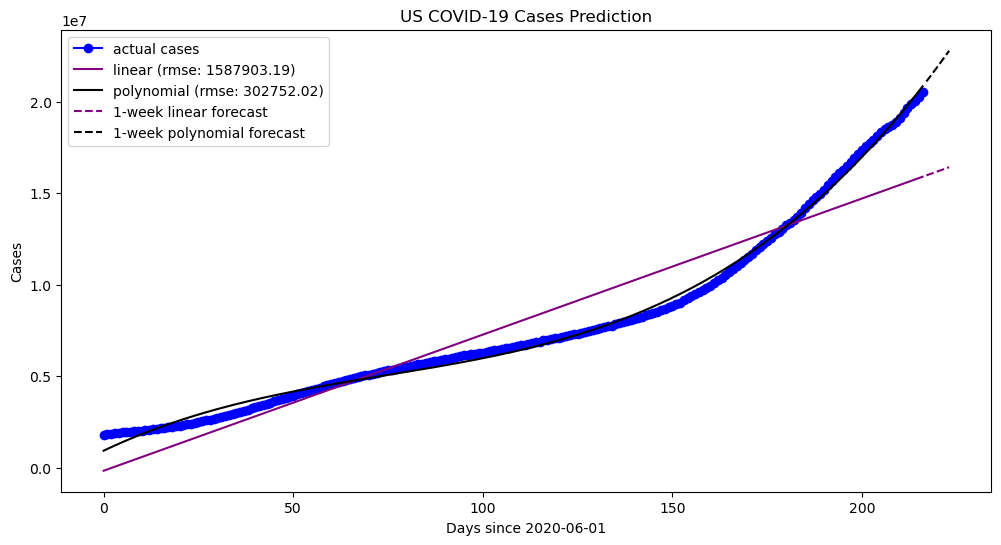

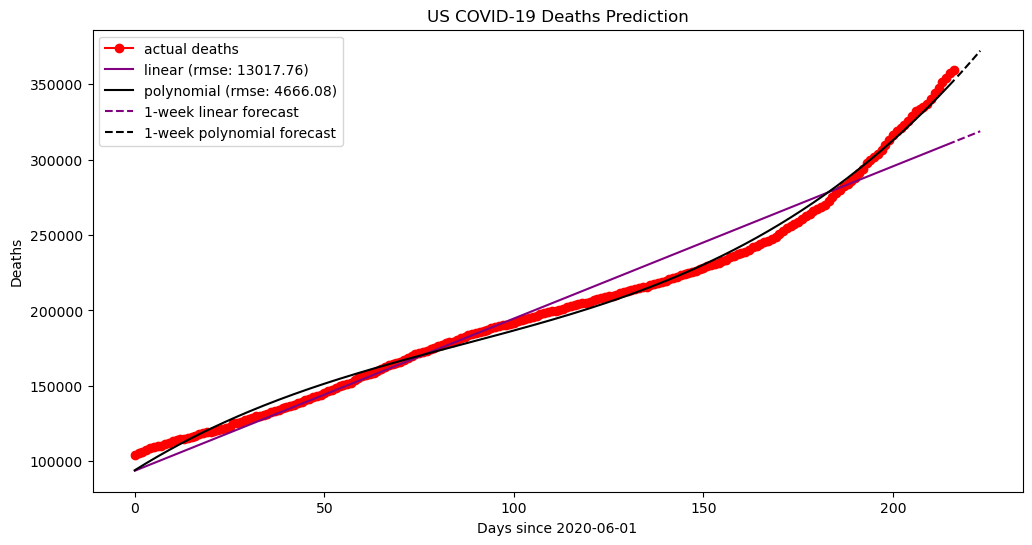

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# separate data for cases and deaths
X = us_data_total[['days_since_start']]
y_cases = us_data_total['cases']
y_deaths = us_data_total['deaths']

# 1-week forecast period (7 days after January 3, 2021)
forecast_days = 7
forecast_start = us_data_total['days_since_start'].max() + 1
forecast_X = np.arange(forecast_start, forecast_start + forecast_days).reshape(-1, 1)

# function to train model, calculate RMSE, and forecast
def train_and_forecast(X, y, forecast_X, degree=3):
    # linear model
    linear_model = LinearRegression().fit(X, y)
    y_pred_linear = linear_model.predict(X)
    rmse_linear = mean_squared_error(y, y_pred_linear, squared=False)
    forecast_linear = linear_model.predict(forecast_X)
    
    # polynomial model
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression().fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    rmse_poly = mean_squared_error(y, y_pred_poly, squared=False)
    forecast_poly = poly_model.predict(poly.transform(forecast_X))
    
    return (y_pred_linear, rmse_linear, forecast_linear, y_pred_poly, rmse_poly, forecast_poly)

# apply function for cases
results_cases = train_and_forecast(X, y_cases, forecast_X)

# apply function for deaths
results_deaths = train_and_forecast(X, y_deaths, forecast_X)

# unpack results for cases and deaths
y_pred_linear_cases, rmse_linear_cases, forecast_linear_cases, y_pred_poly_cases, rmse_poly_cases, forecast_poly_cases = results_cases
y_pred_linear_deaths, rmse_linear_deaths, forecast_linear_deaths, y_pred_poly_deaths, rmse_poly_deaths, forecast_poly_deaths = results_deaths

# plot cases
plt.figure(figsize=(12, 6))
plt.plot(X, y_cases, label='actual cases', marker='o', color='blue')
plt.plot(X, y_pred_linear_cases, label=f'linear (rmse: {rmse_linear_cases:.2f})', color='purple')
plt.plot(X, y_pred_poly_cases, label=f'polynomial (rmse: {rmse_poly_cases:.2f})', color='black')
plt.plot(forecast_X, forecast_linear_cases, '--', color='purple', label='1-week linear forecast')
plt.plot(forecast_X, forecast_poly_cases, '--', color='black', label='1-week polynomial forecast')
plt.title("US COVID-19 Cases Prediction")
plt.xlabel("Days since 2020-06-01")
plt.ylabel("Cases")
plt.legend()
plt.show()

# plot deaths
plt.figure(figsize=(12, 6))
plt.plot(X, y_deaths, label='actual deaths', marker='o', color='red')
plt.plot(X, y_pred_linear_deaths, label=f'linear (rmse: {rmse_linear_deaths:.2f})', color='purple')
plt.plot(X, y_pred_poly_deaths, label=f'polynomial (rmse: {rmse_poly_deaths:.2f})', color='black')
plt.plot(forecast_X, forecast_linear_deaths, '--', color='purple', label='1-week linear forecast')
plt.plot(forecast_X, forecast_poly_deaths, '--', color='black', label='1-week polynomial forecast')
plt.title("US COVID-19 Deaths Prediction")
plt.xlabel("Days since 2020-06-01")
plt.ylabel("Deaths")
plt.legend()
plt.show()


In Step 1, we used two models to see how COVID-19 cases and deaths grew in the US: a simple linear model and a more detailed polynomial model. First, we set the X-axis as the number of days since June 1, 2020, and separated the data into cases and deaths. Then, we applied both models: the linear model shows a straight line, while the polynomial model (degree 3) captures more of the curve in the data. We calculated the RMSE (Root Mean Square Error) to see how well each model fit the actual data, with a lower RMSE meaning a closer match. For cases, the linear model’s RMSE was 1,587,903.19, while the polynomial model’s was much lower at 302,752.02. For deaths, the linear model’s RMSE was 13,017.76, and the polynomial model’s was 4,666.08, showing the polynomial model matched the data better for both cases and deaths.

We also used each model to predict the next week (January 4–10, 2021) and plotted the results. In the plots, actual cases and deaths appear as dots, with the linear trend in purple and the polynomial trend in black. Dashed lines show the 1-week forecast, with the polynomial model better matching the rising trend at the end. Overall, the polynomial model captured the real pattern of cases and deaths more accurately, while the linear model showed a simpler, steady increase and missed the faster rise toward the end.

## Step 2: Discussing the Bias vs. Variance Tradeoff

Cases Plot: In the first graph (US COVID-19 Cases Prediction), the polynomial model fits closely to the actual case data, especially in the later part of the timeframe. The linear model shows a steady increase that doesn’t capture the exponential rise in cases. This difference is clear in the RMSE values, where the polynomial model has a lower RMSE (302752.02) than the linear model (1587903.19), meaning a better fit.

Deaths Plot: In the second graph (US COVID-19 Deaths Prediction), the polynomial model again fits more closely to the actual death data than the linear model. Here, the RMSE for the polynomial model (4666.08) is also lower than the RMSE for the linear model (13017.76), showing a better approx of the trend, during the later phase when deaths were increasing at a faster rate.

Bias-Variance Tradeoff Analysis:
Linear Model:
Bias: High bias is clear in the linear model, it fails to capture the steep rises in cases and deaths observed towards the end of the timeframe. leads to underfitting, where the model oversimplifies the trend.
Variance: The linear model has low variance, it produces a consistent, straightforward trend. this simplicity comes at the cost of the accuracy, especially for the nonlinear growth pattern observed
Polynomial Model:
Bias: The polynomial model has a lower bias, capturing the non-linear growth trend seen in the case and death data. 
Variance: Higher variance is a tradeoff here,the polynomial model is more sensitive to fluctuations in the data. It fits the data closely, which is useful for accuracy but may lead to overfitting, especially if the trend were to change unexpectedly.
Summary
The polynomial model has a more accurate fit for both cases and deaths because of its ability to capture non-linear trends. but this model is more prone to overfitting, which could make it less reliable for long term forecasting without further data. the linear model has lower variance but lacks flexibility to accurately follow the rapid increases in cases and deaths, leading to higher bias.



## Step 3: Comparison of COVID-19 Trends between the US and other countries

Jordan - 
covid cases:
US: Cases rise steadily from June 2020 to January 2021, with a continuous increase through the year. This pattern is an ongoing spread w/o major breaks.
Jordan: Cases go up in waves, with sharp peaks followed by drops. This wave pattern comes from strict lockdowns that temporarily reduced cases before they rise again.
covid deaths:
US: Deaths increase gradually along with cases, going up steady which is showing an ongoing spread.
Jordan: Deaths spike along with case peaks, because the healthcare system faced challenges when cases surge quickly because they dont have access to good healthcare like we do here.
Summary:
The US shows a steady increase in both cases and deaths, while Jordan’s pattern is more up-and-down, due to strict lockdowns and reopenings. 

next country :